# Whatami

I am a simple experiment on using VIME with actor-critic agent setup for MountainCar problem.

Vime performance varies greatly depending on BNN.curiosity parameter so pls pay attention to it :)
* Large curiosity makes agent quickly learn to do weird things, some of which improve it's policy
* Low curiosity is close to vanilla a2c



## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


In [1]:
!wget https://raw.githubusercontent.com/justheuristic/vime/7e20be2231d680187dc79ad3e84b9658996d870c/bnn.py -O bnn.py
!wget https://raw.githubusercontent.com/justheuristic/vime/7e20be2231d680187dc79ad3e84b9658996d870c/curiosity.py -O curiosity.py

--2017-01-14 19:14:23--  https://raw.githubusercontent.com/justheuristic/vime/7e20be2231d680187dc79ad3e84b9658996d870c/bnn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 64:ff9b::9765:2485
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|64:ff9b::9765:2485|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2747 (2.7K) [text/plain]
Saving to: ‘bnn.py’

100%[======================================>] 2,747       --.-K/s   in 0s      

2017-01-14 19:14:23 (35.6 MB/s) - ‘bnn.py’ saved [2747/2747]

--2017-01-14 19:14:24--  https://raw.githubusercontent.com/justheuristic/vime/7e20be2231d680187dc79ad3e84b9658996d870c/curiosity.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 64:ff9b::9765:2485
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|64:ff9b::9765:2485|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3223 (3.1K) [text/plain]
Saving to: ‘curiosity.py’

100%[==

# Experiment setup
* Here we basically just load the game and check that it works

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS="floatX=float32"


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


env: THEANO_FLAGS="floatX=float32"


In [3]:
#global params.
GAME = "MountainCar-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

In [4]:
import gym
env = gym.make(GAME)
env.reset()

obs = env.step(0)[0]

action_names = np.array(["left",'stop',"right"]) #i guess so... i may be wrong
state_size = len(obs)

print(obs)

[2017-01-14 19:14:25,967] Making new env: MountainCar-v0


[-0.52388428 -0.0010054 ]


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [5]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,NonlinearityLayer,batch_norm,dropout
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,state_size))

dense0 = DenseLayer(observation_layer,100,name='dense1')
dense1 = DenseLayer(dense0,256,name='dense2')


Couldn't import dot_parser, loading of dot files will not be possible.


In [6]:
#a layer that predicts Qvalues

policy_layer = DenseLayer(dense1,
                   num_units = env.action_space.n,
                   nonlinearity=lasagne.nonlinearities.softmax,
                   name="q-evaluator layer")


V_layer = DenseLayer(dense1, 1, nonlinearity=None,name="state values")

In [7]:
#Pick actions at random proportionally to te probabilities
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [8]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer,V_layer),
              action_layers=action_layer)


In [9]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer,V_layer),trainable=True)
weights

[dense1.W,
 dense1.b,
 dense2.W,
 dense2.b,
 q-evaluator layer.W,
 q-evaluator layer.b,
 state values.W,
 state values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [10]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=10000)


[2017-01-14 19:14:26,824] Making new env: MountainCar-v0


In [11]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['right' 'left' 'left' 'right' 'left' 'left' 'left']]
[[-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 4.38 ms, sys: 145 µs, total: 4.52 ms
Wall time: 4.41 ms


In [12]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# a2c loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [13]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [14]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import a2c


#Train via actor-critic (see here - https://www.youtube.com/watch?v=KHZVXao4qXs)

elwise_mse_loss = a2c.get_elementwise_objective(policy_seq,V_seq[:,:,0],
                                                       replay.actions[0],
                                                       replay.rewards,
                                                       replay.is_alive,
                                                       gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [15]:
from theano import tensor as T
reg = T.mean((1./policy_seq).sum(axis=-1))
loss += 0.001*reg

In [16]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss,weights,learning_rate=0.001)

In [17]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)


# Demo run

In [18]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-01-14 19:14:42,407] Making new env: MountainCar-v0
[2017-01-14 19:14:42,410] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:14:42,411] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-01-14 19:14:42,412] Starting new video recorder writing to /root/anet/agentnet/examples/records/openaigym.video.0.9649.video000000.mp4
[2017-01-14 19:14:52,827] Tried to pass invalid video frame, marking as broken: Your frame has shape (1, 1, 3), but the VideoRecorder is configured for shape (400, 600, 3).
[2017-01-14 19:14:52,900] Cleaning up paths for broken video recorder: path=/root/anet/agentnet/examples/records/openaigym.video.0.9649.video000000.mp4 metadata_path=/root/anet/agentnet/examples/records/openaigym.video.0.9649.video000000.meta.json
[2

Episode finished after 200 timesteps with reward=-200.0


In [19]:
from IPython.display import HTML

video_path="<fill in url from above>"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Vime

In [20]:
from bnn import bbpwrap, NormalApproximation,sample_output
from lasagne.layers import EmbeddingLayer
import theano.tensor as T
@bbpwrap(NormalApproximation())
class BayesDenseLayer(DenseLayer):pass
@bbpwrap(NormalApproximation())
class BayesEmbLayer(EmbeddingLayer):pass

from curiosity import compile_vime_reward

class BNN:
    curiosity=0.01
    target_rho = 1
    
    l_state = InputLayer((None,state_size),name='state var')
    l_action = InputLayer((None,),input_var=T.ivector())

    l_action_emb = BayesEmbLayer(l_action,env.action_space.n, 3)    
    
    l_concat = lasagne.layers.concat([l_action_emb,l_state])
    
    l_dense = BayesDenseLayer(l_concat,num_units=50,
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    l_out = BayesDenseLayer(l_dense,num_units=state_size,
                            nonlinearity=None)
        
    params = lasagne.layers.get_all_params(l_out,trainable=True)
    ###training###
    pred_states = lasagne.layers.get_output(l_out)
    next_states = T.matrix("next states")
    mse = lasagne.objectives.squared_error(pred_states,next_states).mean()
    
    #replace logposterior with simple regularization on rho cuz we're lazy
    reg = sum([lasagne.objectives.squared_error(rho,target_rho).mean() 
              for rho in lasagne.layers.get_all_params(l_out,rho=True)])
    
    loss = mse+ 0.01*reg
    
    updates = lasagne.updates.adam(loss,params)
    
    train_step = theano.function([l_state.input_var,l_action.input_var,next_states],
                                 loss,updates=updates)
    
    ###sample random sessions from pool###
    observations, = replay.observations
    actions, = replay.actions
    observations_flat = observations[:,:-1].reshape((-1,)+tuple(observations.shape[2:]))
    actions_flat = actions[:,:-1].reshape((-1,))
    next_observations_flat = observations[:,1:].reshape((-1,)+tuple(observations.shape[2:]))
    sample_from_pool = theano.function([],[observations_flat,actions_flat,next_observations_flat])

    
    ###curiosity reward### aka KL(qnew,qold)
    get_vime_reward_elwise = compile_vime_reward(l_out,l_state,l_action,params,n_samples=10)
    
    vime_reward_ma = 10.
    @staticmethod
    def add_vime_reward(observations,actions,rewards,is_alive,h0):
        assert isinstance(observations,np.ndarray)
        observations_flat = observations[:,:-1].reshape((-1,)+observations.shape[2:]).astype('float32')
        actions_flat = actions[:,:-1].reshape((-1,)).astype('int32')
        next_observations_flat = observations[:,1:].reshape((-1,)+observations.shape[2:]).astype('float32')

        vime_rewards = BNN.get_vime_reward_elwise(observations_flat,actions_flat,next_observations_flat)
        vime_rewards = np.concatenate([vime_rewards.reshape(rewards[:,:-1].shape),
                                       np.zeros_like(rewards[:,-1:]),], axis=1)
        #normalize by moving average
        BNN.vime_reward_ma = 0.99*BNN.vime_reward_ma + 0.01*vime_rewards.mean()
        
        surrogate_rewards = rewards + BNN.curiosity/BNN.vime_reward_ma*vime_rewards
        return (observations,actions,surrogate_rewards,is_alive,h0)
    
        


# Training loop

In [21]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [22]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,preprocess=BNN.add_vime_reward)

#pre-train BNN (mitigate training lag on first iterations where BNN is stupid)
for i in tqdm(range(1000)):
    BNN.train_step(*BNN.sample_from_pool())


100%|██████████| 1000/1000 [00:02<00:00, 386.67it/s]


In [23]:

#the loop may take eons to finish.
#consider interrupting early.
loss = 0
for i in tqdm(range(10000)):    
    
    
    #train
    for i in range(10):
        pool.update(SEQ_LENGTH,append=True,preprocess=BNN.add_vime_reward)

    for i in range(10):
        loss = loss*0.99 + train_step()*0.01
    
    for i in range(10):
        BNN.train_step(*BNN.sample_from_pool())

    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        pool_size = pool.experience_replay.rewards.get_value().shape[0]
        print("iter=%i\treward/step=%.5f\tpool_size=%i\tvime ma=%.5f"%(epoch_counter,
                                                         pool_mean_reward,
                                                         pool_size,
                                                         BNN.vime_reward_ma))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 101/10000 [00:17<27:47,  5.94it/s]

iter=100	reward/step=-0.98987	pool_size=2001	vime ma=1.73620


  2%|▏         | 201/10000 [00:34<28:22,  5.75it/s]

iter=200	reward/step=-0.98970	pool_size=3001	vime ma=1.17607


  3%|▎         | 301/10000 [00:51<27:04,  5.97it/s]

iter=300	reward/step=-0.98962	pool_size=4001	vime ma=0.77445


  4%|▍         | 401/10000 [01:08<27:20,  5.85it/s]

iter=400	reward/step=-0.98957	pool_size=5001	vime ma=0.49411


  5%|▍         | 499/10000 [01:25<27:28,  5.76it/s][2017-01-14 19:16:33,792] Making new env: MountainCar-v0
[2017-01-14 19:16:33,797] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:16:33,798] Clearing 3 monitor files from previous run (because force=True was provided)


iter=500	reward/step=-0.98952	pool_size=6001	vime ma=0.36471


[2017-01-14 19:16:34,171] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
  5%|▌         | 501/10000 [01:26<39:51,  3.97it/s]

Current score(mean over 10) = -200.000


  6%|▌         | 601/10000 [01:43<27:36,  5.67it/s]

iter=600	reward/step=-0.98948	pool_size=7001	vime ma=0.25751


  7%|▋         | 701/10000 [02:00<26:42,  5.80it/s]

iter=700	reward/step=-0.98945	pool_size=8001	vime ma=0.19955


  8%|▊         | 801/10000 [02:18<27:25,  5.59it/s]

iter=800	reward/step=-0.98943	pool_size=9001	vime ma=0.13555


  9%|▉         | 901/10000 [02:36<27:18,  5.55it/s]

iter=900	reward/step=-0.98941	pool_size=10000	vime ma=0.09811


 10%|▉         | 999/10000 [02:54<26:24,  5.68it/s][2017-01-14 19:18:02,474] Making new env: MountainCar-v0
[2017-01-14 19:18:02,478] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:18:02,479] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	reward/step=-0.98931	pool_size=10000	vime ma=0.08020


[2017-01-14 19:18:02,859] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 10%|█         | 1001/10000 [02:54<38:21,  3.91it/s]

Current score(mean over 10) = -200.000


 11%|█         | 1101/10000 [03:12<26:09,  5.67it/s]

iter=1100	reward/step=-0.98926	pool_size=10000	vime ma=0.06525


 12%|█▏        | 1201/10000 [03:30<25:34,  5.73it/s]

iter=1200	reward/step=-0.98925	pool_size=10000	vime ma=0.04462


 13%|█▎        | 1301/10000 [03:48<25:23,  5.71it/s]

iter=1300	reward/step=-0.98921	pool_size=10000	vime ma=0.03692


 14%|█▍        | 1401/10000 [04:05<25:32,  5.61it/s]

iter=1400	reward/step=-0.98917	pool_size=10000	vime ma=0.03049


 15%|█▍        | 1499/10000 [04:22<24:49,  5.71it/s][2017-01-14 19:19:31,273] Making new env: MountainCar-v0
[2017-01-14 19:19:31,276] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:19:31,277] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	reward/step=-0.98913	pool_size=10000	vime ma=0.02663


[2017-01-14 19:19:31,677] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 15%|█▌        | 1501/10000 [04:23<36:59,  3.83it/s]

Current score(mean over 10) = -200.000


 16%|█▌        | 1601/10000 [04:41<24:36,  5.69it/s]

iter=1600	reward/step=-0.98909	pool_size=10000	vime ma=0.02198


 17%|█▋        | 1701/10000 [04:59<23:49,  5.81it/s]

iter=1700	reward/step=-0.98903	pool_size=10000	vime ma=0.01954


 18%|█▊        | 1801/10000 [05:16<23:16,  5.87it/s]

iter=1800	reward/step=-0.98885	pool_size=10000	vime ma=0.01844


 19%|█▉        | 1901/10000 [05:34<23:39,  5.71it/s]

iter=1900	reward/step=-0.98852	pool_size=10000	vime ma=0.01846


 20%|█▉        | 1999/10000 [05:50<23:08,  5.76it/s][2017-01-14 19:20:59,260] Making new env: MountainCar-v0
[2017-01-14 19:20:59,263] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:20:59,264] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	reward/step=-0.98819	pool_size=10000	vime ma=0.01844


[2017-01-14 19:20:59,576] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 20%|██        | 2001/10000 [05:51<32:26,  4.11it/s]

Current score(mean over 10) = -152.300


 21%|██        | 2101/10000 [06:09<23:19,  5.65it/s]

iter=2100	reward/step=-0.98783	pool_size=10000	vime ma=0.01813


 22%|██▏       | 2201/10000 [06:27<23:16,  5.58it/s]

iter=2200	reward/step=-0.98744	pool_size=10000	vime ma=0.01836


 23%|██▎       | 2301/10000 [06:45<22:54,  5.60it/s]

iter=2300	reward/step=-0.98707	pool_size=10000	vime ma=0.01929


 24%|██▍       | 2401/10000 [07:03<22:15,  5.69it/s]

iter=2400	reward/step=-0.98670	pool_size=10000	vime ma=0.02002


 25%|██▍       | 2499/10000 [07:20<22:20,  5.60it/s][2017-01-14 19:22:28,940] Making new env: MountainCar-v0
[2017-01-14 19:22:28,942] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:22:28,944] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2500	reward/step=-0.98636	pool_size=10000	vime ma=0.01988


[2017-01-14 19:22:29,203] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 25%|██▌       | 2501/10000 [07:21<29:04,  4.30it/s]

Current score(mean over 10) = -131.100


 26%|██▌       | 2601/10000 [07:39<21:42,  5.68it/s]

iter=2600	reward/step=-0.98603	pool_size=10000	vime ma=0.02039


 27%|██▋       | 2701/10000 [07:56<21:26,  5.67it/s]

iter=2700	reward/step=-0.98570	pool_size=10000	vime ma=0.02545


 28%|██▊       | 2801/10000 [08:15<21:08,  5.68it/s]

iter=2800	reward/step=-0.98550	pool_size=10000	vime ma=0.02543


 29%|██▉       | 2901/10000 [08:33<21:38,  5.47it/s]

iter=2900	reward/step=-0.98543	pool_size=10000	vime ma=0.02535


 30%|██▉       | 2999/10000 [08:51<21:34,  5.41it/s][2017-01-14 19:23:59,802] Making new env: MountainCar-v0
[2017-01-14 19:23:59,805] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:23:59,806] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3000	reward/step=-0.98535	pool_size=10000	vime ma=0.02871


[2017-01-14 19:24:00,026] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 30%|███       | 3001/10000 [08:52<26:30,  4.40it/s]

Current score(mean over 10) = -117.100


 31%|███       | 3101/10000 [09:09<20:34,  5.59it/s]

iter=3100	reward/step=-0.98531	pool_size=10000	vime ma=0.03177


 32%|███▏      | 3201/10000 [09:28<21:24,  5.29it/s]

iter=3200	reward/step=-0.98537	pool_size=10000	vime ma=0.03298


 33%|███▎      | 3301/10000 [09:46<20:23,  5.47it/s]

iter=3300	reward/step=-0.98539	pool_size=10000	vime ma=0.03087


 34%|███▍      | 3401/10000 [10:05<20:59,  5.24it/s]

iter=3400	reward/step=-0.98539	pool_size=10000	vime ma=0.03484


 35%|███▍      | 3499/10000 [10:23<19:56,  5.43it/s][2017-01-14 19:25:31,533] Making new env: MountainCar-v0
[2017-01-14 19:25:31,536] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:25:31,537] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3500	reward/step=-0.98535	pool_size=10000	vime ma=0.03731


[2017-01-14 19:25:31,765] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 35%|███▌      | 3500/10000 [10:23<27:35,  3.93it/s]

Current score(mean over 10) = -111.400


 36%|███▌      | 3601/10000 [10:42<19:38,  5.43it/s]

iter=3600	reward/step=-0.98530	pool_size=10000	vime ma=0.03967


 37%|███▋      | 3701/10000 [11:00<20:05,  5.23it/s]

iter=3700	reward/step=-0.98525	pool_size=10000	vime ma=0.03859


 38%|███▊      | 3801/10000 [11:18<18:13,  5.67it/s]

iter=3800	reward/step=-0.98517	pool_size=10000	vime ma=0.04288


 39%|███▉      | 3901/10000 [11:37<18:21,  5.54it/s]

iter=3900	reward/step=-0.98513	pool_size=10000	vime ma=0.04379


 40%|███▉      | 3999/10000 [11:55<18:22,  5.44it/s][2017-01-14 19:27:03,463] Making new env: MountainCar-v0
[2017-01-14 19:27:03,465] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:27:03,466] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4000	reward/step=-0.98510	pool_size=10000	vime ma=0.04581


[2017-01-14 19:27:03,699] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 40%|████      | 4001/10000 [11:55<23:37,  4.23it/s]

Current score(mean over 10) = -113.900


 41%|████      | 4101/10000 [12:14<17:45,  5.54it/s]

iter=4100	reward/step=-0.98508	pool_size=10000	vime ma=0.04525


 42%|████▏     | 4201/10000 [12:33<17:37,  5.48it/s]

iter=4200	reward/step=-0.98499	pool_size=10000	vime ma=0.04779


 43%|████▎     | 4301/10000 [12:51<17:39,  5.38it/s]

iter=4300	reward/step=-0.98490	pool_size=10000	vime ma=0.05222


 44%|████▍     | 4400/10000 [13:09<16:55,  5.52it/s]

iter=4400	reward/step=-0.98486	pool_size=10000	vime ma=0.05298


 45%|████▍     | 4499/10000 [13:27<16:50,  5.45it/s][2017-01-14 19:28:36,215] Making new env: MountainCar-v0
[2017-01-14 19:28:36,281] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:28:36,287] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4500	reward/step=-0.98484	pool_size=10000	vime ma=0.05615


[2017-01-14 19:28:36,533] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 45%|████▌     | 4500/10000 [13:28<25:48,  3.55it/s]

Current score(mean over 10) = -112.800


 46%|████▌     | 4601/10000 [13:46<16:05,  5.59it/s]

iter=4600	reward/step=-0.98482	pool_size=10000	vime ma=0.05942


 47%|████▋     | 4701/10000 [14:05<17:34,  5.02it/s]

iter=4700	reward/step=-0.98484	pool_size=10000	vime ma=0.05844


 48%|████▊     | 4801/10000 [14:24<16:18,  5.31it/s]

iter=4800	reward/step=-0.98485	pool_size=10000	vime ma=0.06298


 49%|████▉     | 4901/10000 [14:43<15:41,  5.41it/s]

iter=4900	reward/step=-0.98486	pool_size=10000	vime ma=0.05928


 50%|████▉     | 4999/10000 [15:01<15:17,  5.45it/s][2017-01-14 19:30:10,140] Making new env: MountainCar-v0
[2017-01-14 19:30:10,144] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:30:10,146] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5000	reward/step=-0.98485	pool_size=10000	vime ma=0.06338


[2017-01-14 19:30:10,366] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 50%|█████     | 5001/10000 [15:02<19:00,  4.38it/s]

Current score(mean over 10) = -115.200


 51%|█████     | 5101/10000 [15:21<14:58,  5.45it/s]

iter=5100	reward/step=-0.98483	pool_size=10000	vime ma=0.06329


 52%|█████▏    | 5200/10000 [15:41<20:47,  3.85it/s]

iter=5200	reward/step=-0.98482	pool_size=10000	vime ma=0.06664


 53%|█████▎    | 5300/10000 [16:07<21:48,  3.59it/s]

iter=5300	reward/step=-0.98483	pool_size=10000	vime ma=0.06879


 54%|█████▍    | 5400/10000 [16:33<19:44,  3.88it/s]

iter=5400	reward/step=-0.98482	pool_size=10000	vime ma=0.07210


 55%|█████▍    | 5499/10000 [16:59<20:32,  3.65it/s][2017-01-14 19:32:07,530] Making new env: MountainCar-v0
[2017-01-14 19:32:07,532] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:32:07,533] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5500	reward/step=-0.98481	pool_size=10000	vime ma=0.07346


[2017-01-14 19:32:07,807] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 55%|█████▌    | 5501/10000 [16:59<23:49,  3.15it/s]

Current score(mean over 10) = -134.700


 56%|█████▌    | 5600/10000 [17:24<18:42,  3.92it/s]

iter=5600	reward/step=-0.98481	pool_size=10000	vime ma=0.07498


 57%|█████▋    | 5700/10000 [17:49<16:23,  4.37it/s]

iter=5700	reward/step=-0.98480	pool_size=10000	vime ma=0.07963


 58%|█████▊    | 5800/10000 [18:15<16:20,  4.28it/s]

iter=5800	reward/step=-0.98483	pool_size=10000	vime ma=0.08101


 59%|█████▉    | 5901/10000 [18:41<16:18,  4.19it/s]

iter=5900	reward/step=-0.98483	pool_size=10000	vime ma=0.07980


 60%|█████▉    | 5999/10000 [19:05<16:21,  4.08it/s][2017-01-14 19:34:14,387] Making new env: MountainCar-v0
[2017-01-14 19:34:14,390] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:34:14,391] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6000	reward/step=-0.98483	pool_size=10000	vime ma=0.08466


[2017-01-14 19:34:14,616] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 60%|██████    | 6000/10000 [19:06<20:12,  3.30it/s]

Current score(mean over 10) = -109.800


 61%|██████    | 6100/10000 [19:32<19:24,  3.35it/s]

iter=6100	reward/step=-0.98483	pool_size=10000	vime ma=0.08453


 62%|██████▏   | 6200/10000 [19:58<15:10,  4.17it/s]

iter=6200	reward/step=-0.98485	pool_size=10000	vime ma=0.09040


 63%|██████▎   | 6300/10000 [20:24<16:42,  3.69it/s]

iter=6300	reward/step=-0.98485	pool_size=10000	vime ma=0.08749


 64%|██████▍   | 6400/10000 [20:51<17:07,  3.50it/s]

iter=6400	reward/step=-0.98483	pool_size=10000	vime ma=0.08890


 65%|██████▍   | 6499/10000 [21:17<16:32,  3.53it/s][2017-01-14 19:36:25,856] Making new env: MountainCar-v0
[2017-01-14 19:36:25,859] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:36:25,861] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6500	reward/step=-0.98484	pool_size=10000	vime ma=0.09097


[2017-01-14 19:36:26,109] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 65%|██████▌   | 6500/10000 [21:17<21:13,  2.75it/s]

Current score(mean over 10) = -118.800


 66%|██████▌   | 6601/10000 [21:43<13:42,  4.13it/s]

iter=6600	reward/step=-0.98485	pool_size=10000	vime ma=0.09032


 67%|██████▋   | 6700/10000 [22:09<12:35,  4.37it/s]

iter=6700	reward/step=-0.98483	pool_size=10000	vime ma=0.09460


 68%|██████▊   | 6800/10000 [22:36<14:49,  3.60it/s]

iter=6800	reward/step=-0.98481	pool_size=10000	vime ma=0.09417


 69%|██████▉   | 6901/10000 [23:03<14:17,  3.61it/s]

iter=6900	reward/step=-0.98481	pool_size=10000	vime ma=0.09405


 70%|██████▉   | 6999/10000 [23:27<14:32,  3.44it/s][2017-01-14 19:38:36,176] Making new env: MountainCar-v0
[2017-01-14 19:38:36,180] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:38:36,182] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7000	reward/step=-0.98483	pool_size=10000	vime ma=0.10473


[2017-01-14 19:38:36,443] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 70%|███████   | 7000/10000 [23:28<17:24,  2.87it/s]

Current score(mean over 10) = -123.000


 71%|███████   | 7100/10000 [23:54<12:48,  3.77it/s]

iter=7100	reward/step=-0.98487	pool_size=10000	vime ma=0.10080


 72%|███████▏  | 7201/10000 [24:21<11:51,  3.93it/s]

iter=7200	reward/step=-0.98488	pool_size=10000	vime ma=0.10473


 73%|███████▎  | 7300/10000 [24:48<10:45,  4.18it/s]

iter=7300	reward/step=-0.98488	pool_size=10000	vime ma=0.10983


 74%|███████▍  | 7400/10000 [25:14<11:03,  3.92it/s]

iter=7400	reward/step=-0.98490	pool_size=10000	vime ma=0.10270


 75%|███████▍  | 7499/10000 [25:40<09:41,  4.30it/s][2017-01-14 19:40:49,255] Making new env: MountainCar-v0
[2017-01-14 19:40:49,258] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:40:49,259] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7500	reward/step=-0.98490	pool_size=10000	vime ma=0.10862


[2017-01-14 19:40:49,488] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 75%|███████▌  | 7500/10000 [25:41<12:17,  3.39it/s]

Current score(mean over 10) = -114.000


 76%|███████▌  | 7601/10000 [26:07<09:19,  4.28it/s]

iter=7600	reward/step=-0.98486	pool_size=10000	vime ma=0.10269


 77%|███████▋  | 7700/10000 [26:33<10:03,  3.81it/s]

iter=7700	reward/step=-0.98487	pool_size=10000	vime ma=0.10658


 78%|███████▊  | 7800/10000 [26:59<09:03,  4.05it/s]

iter=7800	reward/step=-0.98486	pool_size=10000	vime ma=0.11045


 79%|███████▉  | 7900/10000 [27:25<09:16,  3.78it/s]

iter=7900	reward/step=-0.98483	pool_size=10000	vime ma=0.11523


 80%|███████▉  | 7999/10000 [27:50<09:18,  3.58it/s][2017-01-14 19:42:59,402] Making new env: MountainCar-v0
[2017-01-14 19:42:59,406] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:42:59,407] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8000	reward/step=-0.98483	pool_size=10000	vime ma=0.11395


[2017-01-14 19:42:59,678] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 80%|████████  | 8000/10000 [27:51<11:26,  2.91it/s]

Current score(mean over 10) = -131.100


 81%|████████  | 8100/10000 [28:17<08:22,  3.78it/s]

iter=8100	reward/step=-0.98476	pool_size=10000	vime ma=0.12239


 82%|████████▏ | 8201/10000 [28:44<07:24,  4.05it/s]

iter=8200	reward/step=-0.98475	pool_size=10000	vime ma=0.11894


 83%|████████▎ | 8300/10000 [29:10<06:25,  4.41it/s]

iter=8300	reward/step=-0.98475	pool_size=10000	vime ma=0.11917


 84%|████████▍ | 8400/10000 [29:37<06:41,  3.99it/s]

iter=8400	reward/step=-0.98472	pool_size=10000	vime ma=0.11930


 85%|████████▍ | 8499/10000 [30:02<05:54,  4.23it/s][2017-01-14 19:45:11,338] Making new env: MountainCar-v0
[2017-01-14 19:45:11,340] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:45:11,341] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8500	reward/step=-0.98475	pool_size=10000	vime ma=0.12119


[2017-01-14 19:45:11,560] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 85%|████████▌ | 8500/10000 [30:03<08:07,  3.08it/s]

Current score(mean over 10) = -108.700


 86%|████████▌ | 8600/10000 [30:29<05:31,  4.23it/s]

iter=8600	reward/step=-0.98476	pool_size=10000	vime ma=0.12762


 87%|████████▋ | 8701/10000 [30:56<04:56,  4.38it/s]

iter=8700	reward/step=-0.98476	pool_size=10000	vime ma=0.12571


 88%|████████▊ | 8801/10000 [31:22<05:11,  3.85it/s]

iter=8800	reward/step=-0.98479	pool_size=10000	vime ma=0.12743


 89%|████████▉ | 8901/10000 [31:48<04:32,  4.03it/s]

iter=8900	reward/step=-0.98479	pool_size=10000	vime ma=0.13415


 90%|████████▉ | 8999/10000 [32:14<04:35,  3.63it/s][2017-01-14 19:47:22,597] Making new env: MountainCar-v0
[2017-01-14 19:47:22,601] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:47:22,603] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9000	reward/step=-0.98478	pool_size=10000	vime ma=0.12363


[2017-01-14 19:47:22,864] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 90%|█████████ | 9000/10000 [32:14<05:38,  2.95it/s]

Current score(mean over 10) = -107.100


 91%|█████████ | 9100/10000 [32:42<03:47,  3.96it/s]

iter=9100	reward/step=-0.98481	pool_size=10000	vime ma=0.12839


 92%|█████████▏| 9200/10000 [33:08<03:48,  3.50it/s]

iter=9200	reward/step=-0.98480	pool_size=10000	vime ma=0.13531


 93%|█████████▎| 9300/10000 [33:34<03:00,  3.88it/s]

iter=9300	reward/step=-0.98481	pool_size=10000	vime ma=0.13077


 94%|█████████▍| 9400/10000 [34:01<02:26,  4.09it/s]

iter=9400	reward/step=-0.98480	pool_size=10000	vime ma=0.13417


 95%|█████████▍| 9499/10000 [34:26<02:10,  3.83it/s][2017-01-14 19:49:34,970] Making new env: MountainCar-v0
[2017-01-14 19:49:34,973] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:49:34,975] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9500	reward/step=-0.98478	pool_size=10000	vime ma=0.12933


[2017-01-14 19:49:35,216] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
 95%|█████████▌| 9500/10000 [34:27<02:38,  3.16it/s]

Current score(mean over 10) = -110.600


 96%|█████████▌| 9600/10000 [34:54<02:13,  2.99it/s]

iter=9600	reward/step=-0.98480	pool_size=10000	vime ma=0.12547


 97%|█████████▋| 9700/10000 [35:20<01:14,  4.00it/s]

iter=9700	reward/step=-0.98478	pool_size=10000	vime ma=0.13141


 98%|█████████▊| 9800/10000 [35:47<00:58,  3.40it/s]

iter=9800	reward/step=-0.98477	pool_size=10000	vime ma=0.13615


 99%|█████████▉| 9900/10000 [36:13<00:22,  4.37it/s]

iter=9900	reward/step=-0.98481	pool_size=10000	vime ma=0.12573


100%|█████████▉| 9999/10000 [36:40<00:00,  3.89it/s][2017-01-14 19:51:48,905] Making new env: MountainCar-v0
[2017-01-14 19:51:48,908] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 19:51:48,909] Clearing 2 monitor files from previous run (because force=True was provided)


iter=10000	reward/step=-0.98480	pool_size=10000	vime ma=0.13534


[2017-01-14 19:51:49,132] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/anet/agentnet/examples/records')
100%|██████████| 10000/10000 [36:40<00:00,  3.21it/s]

Current score(mean over 10) = -109.100


In [24]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda (k,v):k))

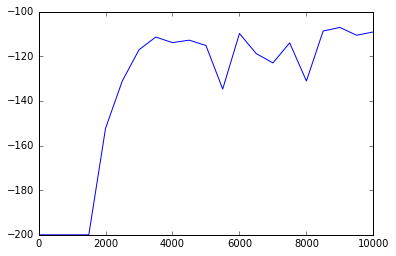

In [25]:
plt.plot(iters,map(np.mean,session_rewards))

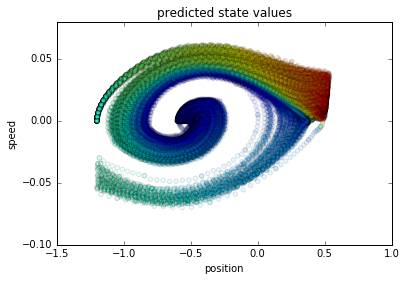

In [26]:

_,_,_,_,(pool_policy,pool_V) = agent.get_sessions(
    pool.experience_replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,)

plt.scatter(
    *pool.experience_replay.observations[0].get_value().reshape([-1,2]).T,
    c = pool_V.ravel().eval(),
    alpha = 0.1)
plt.title("predicted state values")
plt.xlabel("position")
plt.ylabel("speed")

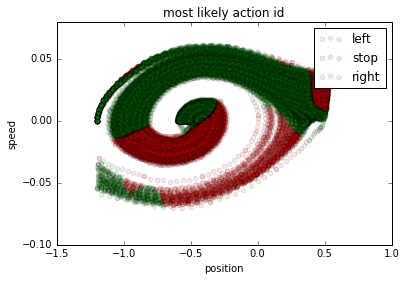

In [27]:
obs_x,obs_y = pool.experience_replay.observations[0].get_value().reshape([-1,2]).T
optimal_actid = pool_policy.argmax(-1).ravel().eval()

for i in range(3):
    sel = optimal_actid==i
    plt.scatter(obs_x[sel],obs_y[sel],
                c=['red','blue','green'][i],
                alpha = 0.1,label=action_names[i])
    
plt.title("most likely action id")
plt.xlabel("position")
plt.ylabel("speed")
plt.legend(loc='best')